In [7]:
%pip install kaggle

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [5]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2025-09-11 12:45:45.400343: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 12:45:45.411202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757594745.424478    1602 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757594745.428589    1602 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-11 12:45:45.443406: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
import os
import zipfile as ZipFile
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageOps
import numpy as np

from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import classification_report


from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    Resize
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.6.dev2536
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5a50bb444bdb59d777e697b87248508b7b256efa
MONAI __file__: /opt/conda/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu126
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UN

In [7]:
# Setăm variabila de mediu MONAI_DATA_DIRECTORY
os.environ["MONAI_DATA_DIRECTORY"] = "MONAI"

# Verificăm că variabila a fost setată corect
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

MONAI


In [36]:
for item in os.listdir(data_dir):
    src = os.path.join(data_dir, item)
    dst = os.path.join(root_dir, item)
    shutil.move(src, dst)

In [10]:
# resource = "https://www.kaggle.com/api/v1/datasets/download/sartajbhuvaji/brain-tumor-classification-mri"
compressed_file = os.path.join(root_dir, "archive")
data_dir = os.path.join(root_dir, "Training")
os.makedirs(data_dir, exist_ok=True)

# if not os.path.exists(data_dir):
#     download_and_extract(resource, compressed_file, root_dir)

In [8]:
set_determinism(seed=42)

In [11]:
print(compressed_file)

MONAI/archive


Read train + validation

In [12]:
# Get class names, ignoring hidden folders
class_names = sorted(
    x for x in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, x)) and not x.startswith('.')
)
num_class = len(class_names)

# Collect image file paths for each class
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
        if not x.startswith('.')  # ignore hidden files
    ]
    for i in range(num_class)
]

# Number of images per class
num_each = [len(image_files[i]) for i in range(num_class)]

# Flatten lists for all images and their labels
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])

num_total = len(image_class)

# Get image dimensions from first image
if num_total > 0:
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
else:
    image_width = image_height = 0

# Print summary
print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")


Total image count: 2870
Image dimensions: 512 x 512
Label names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Label counts: [826, 822, 395, 827]


Text(0.5, 1.0, 'Distribution of Classes')

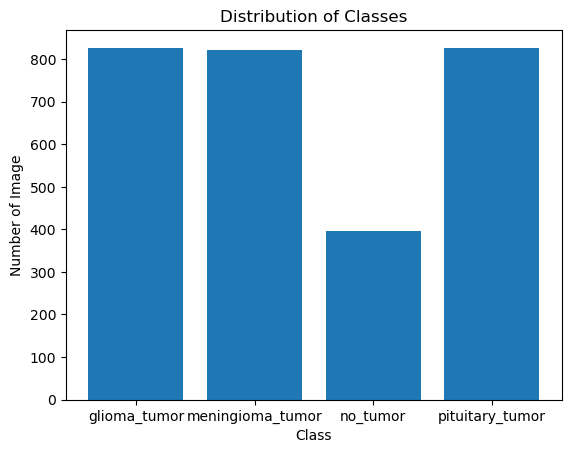

In [13]:
plt.bar(x=class_names, height=num_each)
plt.xlabel("Class")
plt.ylabel("Number of Image")
plt.title("Distribution of Classes")

read test


In [14]:
import os
import PIL.Image

# Path to test data
test_dir = os.path.join(root_dir, "Testing")

# Get class names, ignoring hidden folders
class_test = sorted(
    x for x in os.listdir(test_dir)
    if os.path.isdir(os.path.join(test_dir, x)) and not x.startswith('.')
)
num_class_test = len(class_test)

# Collect image file paths for each class
image_files_test = [
    [
        os.path.join(test_dir, class_test[i], x)
        for x in os.listdir(os.path.join(test_dir, class_test[i]))
        if not x.startswith('.')  # ignore hidden files
    ]
    for i in range(num_class_test)
]

# Number of images per class
num_each_test = [len(image_files_test[i]) for i in range(num_class_test)]

# Flatten lists for all images and their labels
image_files_list_test = []
image_class_test = []

for i in range(num_class_test):
    image_files_list_test.extend(image_files_test[i])
    image_class_test.extend([i] * num_each_test[i])

num_total_test = len(image_class_test)

# Get image dimensions from first image
if num_total_test > 0:
    image_width, image_height = PIL.Image.open(image_files_list_test[0]).size
else:
    image_width = image_height = 0

# Print summary
print(f"Total image count: {num_total_test}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_test}")
print(f"Label counts: {num_each_test}")

Total image count: 394
Image dimensions: 339 x 406
Label names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Label counts: [100, 115, 105, 74]


In [64]:
class LeNet(nn.Module):
    def __init__(self, in_size, out_size):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_size, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_size)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        return x

    def name(self):
        return "LeNet"

In [65]:
use_cuda = torch.cuda.is_available()
device = "cuda"
model = LeNet(3, num_class).to(device)


In [17]:
use_cuda = torch.cuda.is_available()
device = "cuda"
model = resnet50(pretrained=True).to(device)

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, num_class)

# Freeze all layers except layer4 and fc
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

In [18]:
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), learning_rate)

loss_function = torch.nn.CrossEntropyLoss()

In [19]:
val_frac = 0.2
train_frac = 0.8
length = len(image_files_list)
train_length = int(train_frac * length)
indices = np.arange(length)
np.random.shuffle(indices)


val_split = int(val_frac * length)
train_indices = indices[val_split:]
val_indices = indices[:val_split]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]


test_x = [image_files_list_test[i] for i in range(len(image_files_list_test))]
test_y = [image_class_test[i] for i in range(len(image_class_test))]

val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]


print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}")

Training count: 2296, Validation count: 574


In [20]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        Resize(spatial_size=(32, 32))


    ]
)

val_transforms = Compose(
[
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize(spatial_size=(32, 32))
    ]
)

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [21]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_files, labels, transforms):
        """
        Inițializează dataset-ul.

        Parameters:
        - root_dir (str): Directorul de unde sunt încărcate imaginile (train / test).
        - transform (callable, optional): Transformările de aplicat pe imagini (e.g., augmentare, redimensionare).
        """
        self.transforms = transforms
        self.image_files = image_files
        self.labels = labels


        # # Mapăm fiecare categorie de tumoră la un label numeric
        # self.class_to_label = {
        #     "glioma_tumor": 0,
        #     "meningioma_tumor": 1,
        #     "no_tumor": 2,
        #     "pituitary_tumor": 3
        # }

    def __len__(self):
        """
        Returnează numărul total de imagini din dataset.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Încărcați și returnați o imagine și eticheta corespunzătoare pe baza indexului.
        """
        image = self.image_files[idx]
        image = self.transforms(image)
        label = self.labels[idx]

        return image, label

train_ds = BrainTumorDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=10)

val_ds = BrainTumorDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True, num_workers=10)

test_ds = BrainTumorDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True, num_workers=10)

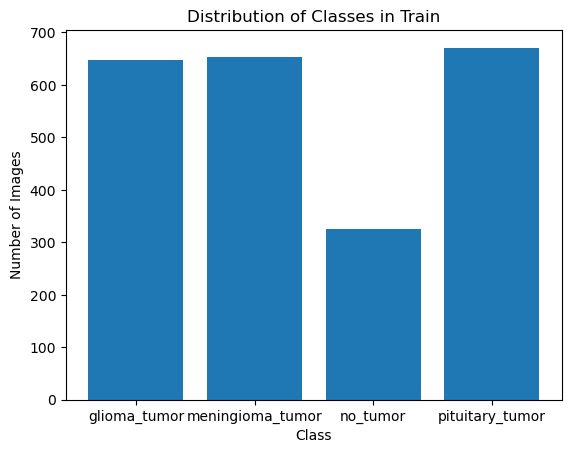

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [22]:
num_classes = len(class_names)
counts = [sum(1 for data in train_y if data == i) for i in range(num_classes)]

plt.bar(x=class_names, height=counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Classes in Train")
plt.show()

print(class_names)


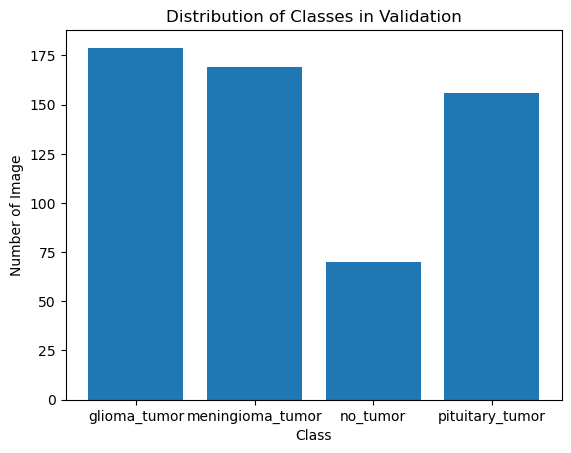

In [71]:
counts = [sum(1 for data in val_y if data == i) for i in range(4)]

plt.bar(x=class_names, height=counts)
plt.xlabel("Class")
plt.ylabel("Number of Image")
plt.title("Distribution of Classes in Validation")
plt.show()

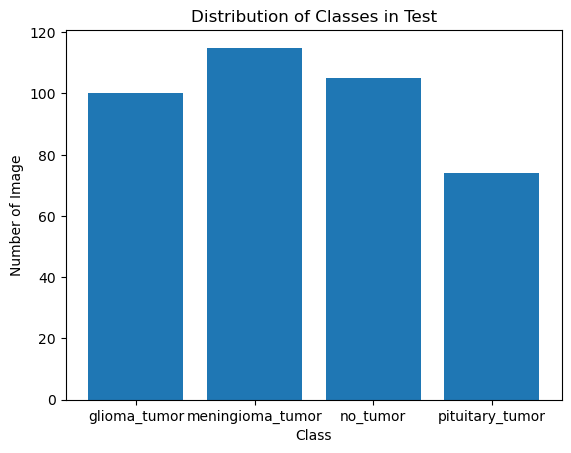

In [72]:
counts = [sum(1 for data in test_y if data == i) for i in range(4)]

plt.bar(x=class_names, height=counts)
plt.xlabel("Class")
plt.ylabel("Number of Image")
plt.title("Distribution of Classes in Test")
plt.show()

Examinarea tipurilor de tumori

Class: glioma_tumor


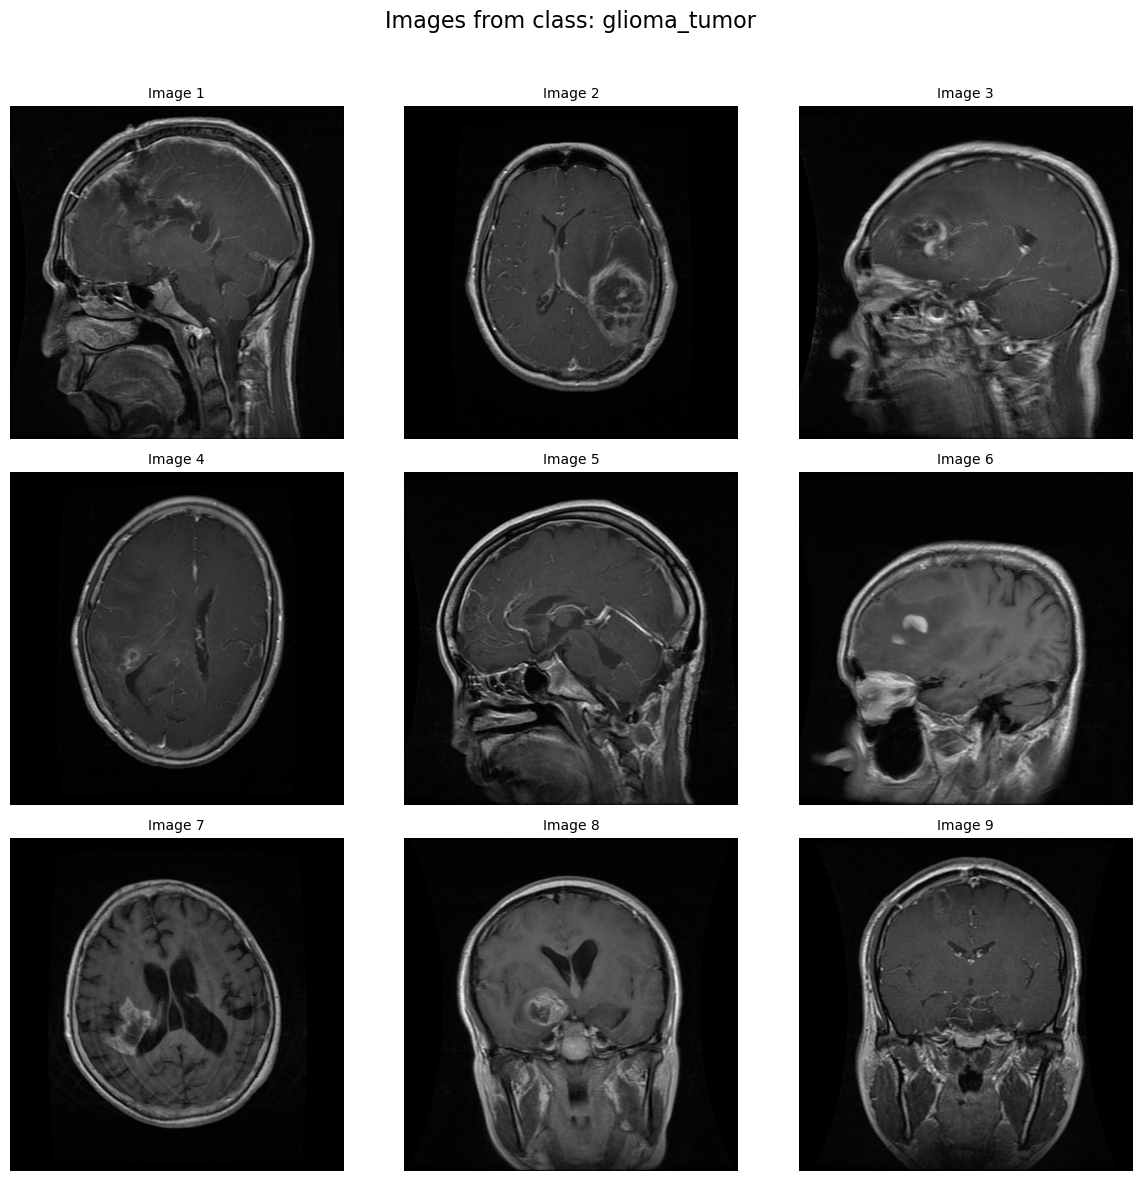

Class: meningioma_tumor


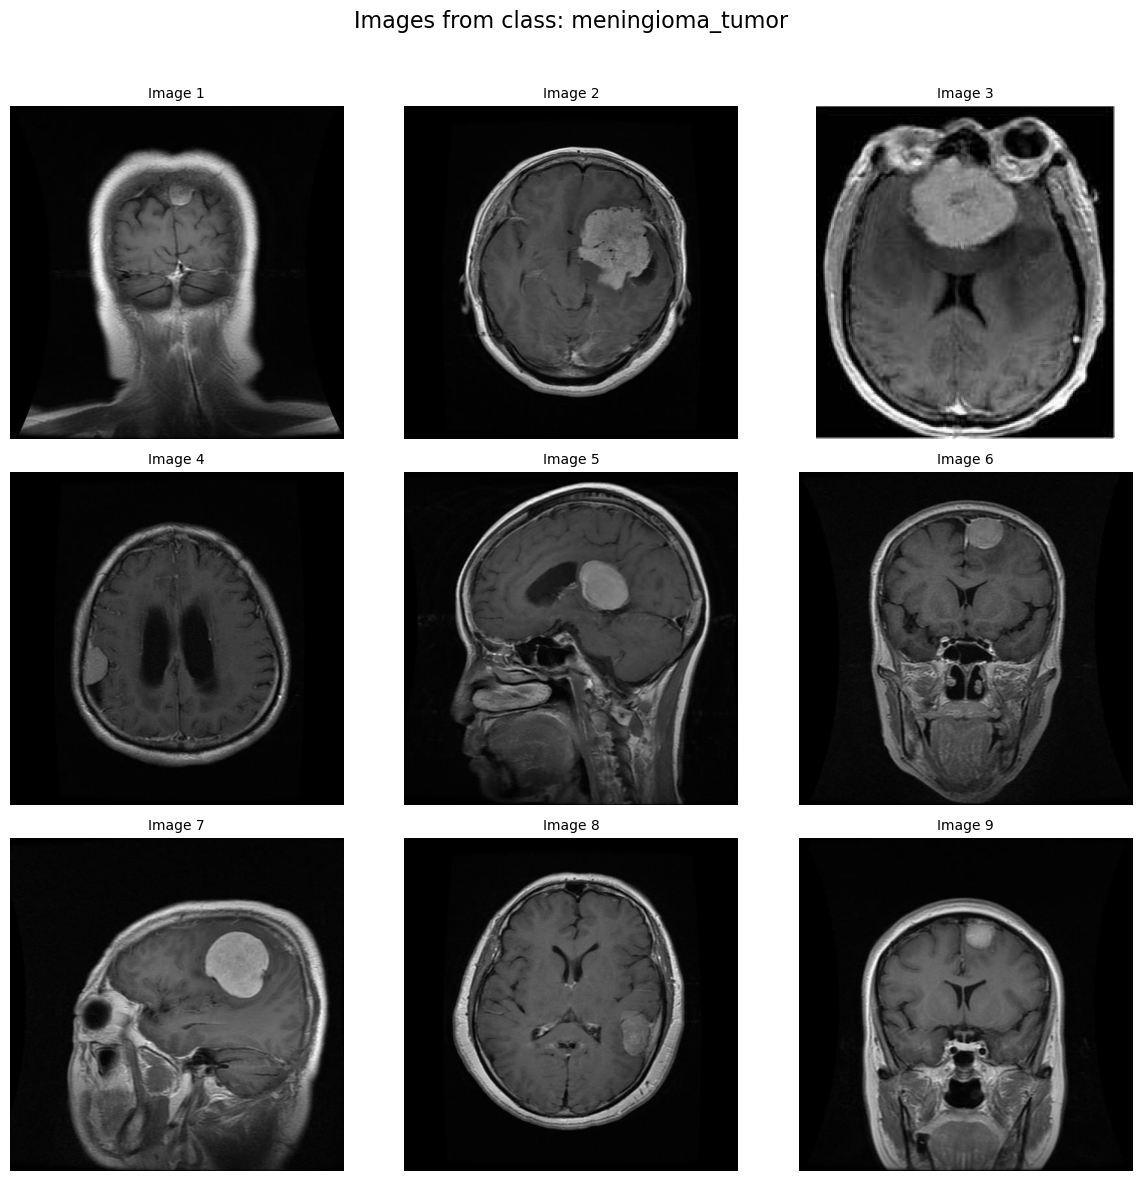

Class: no_tumor


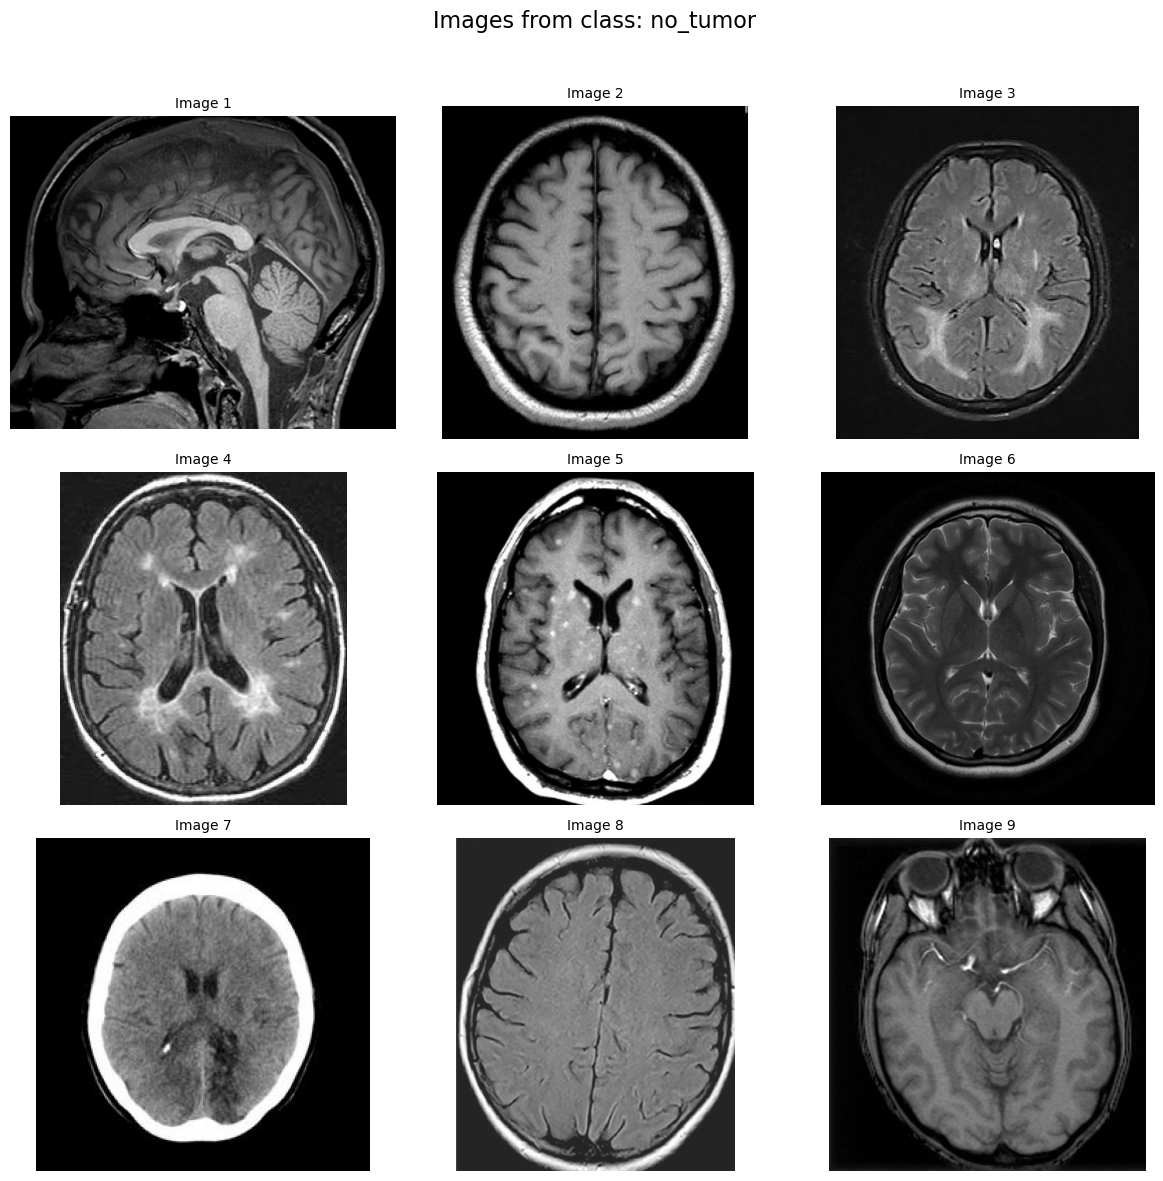

Class: pituitary_tumor


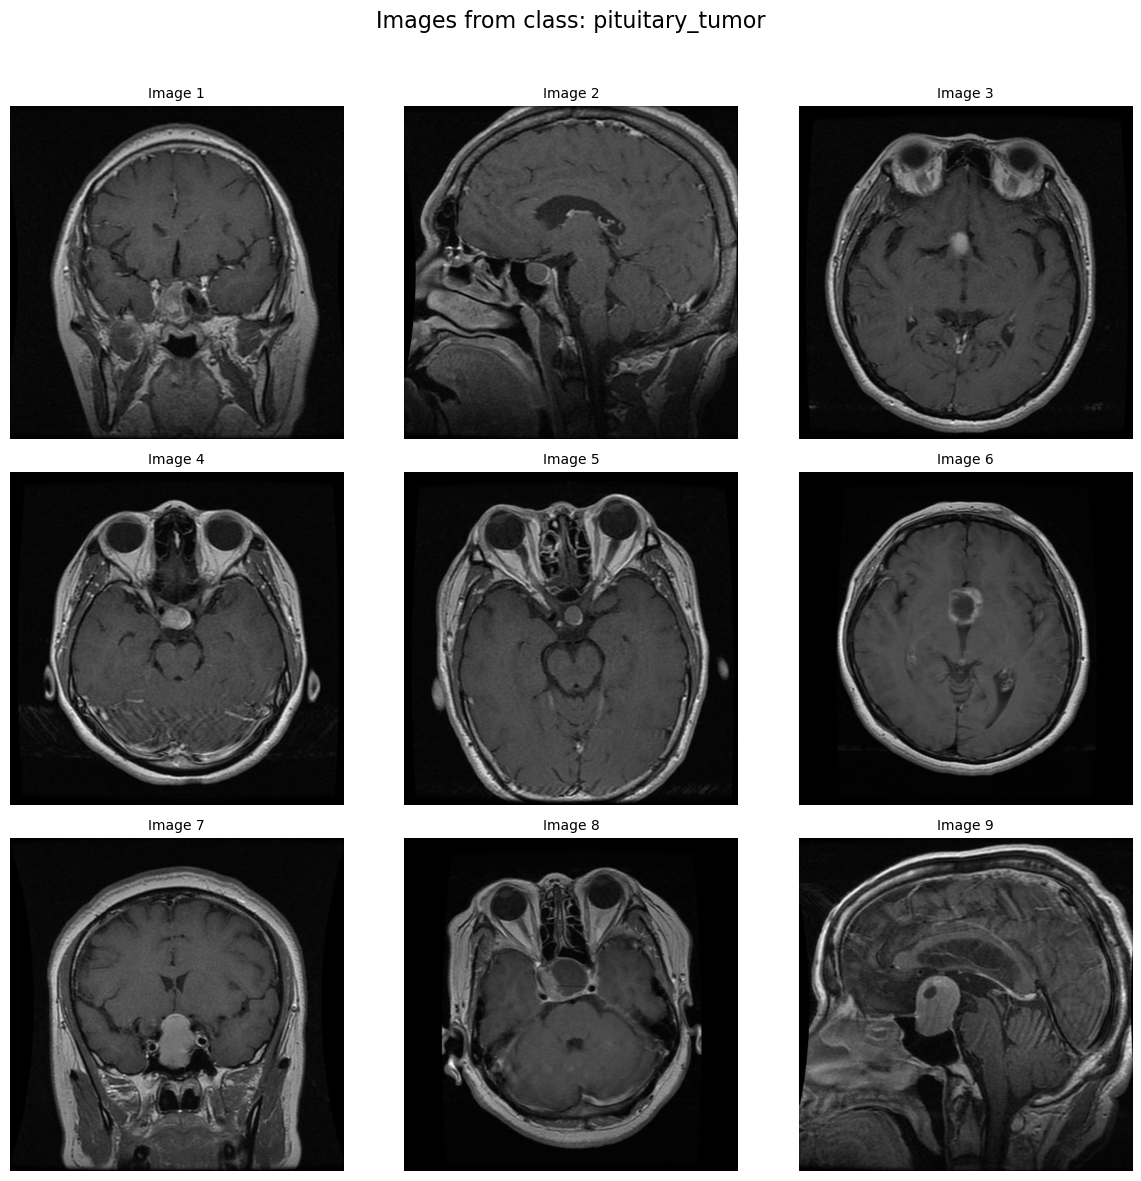

In [73]:
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    print(f"Class: {class_name}")

    # Initialize a figure with a 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle(f"Images from class: {class_name}", fontsize=16)

    # Limit to 9 images per class (3x3 grid)
    max_images = 0

    for idx, img_name in enumerate(os.listdir(class_dir)):
        if max_images == 9:
            break

        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)

        # Find the current subplot in the 3x3 grid
        row, col = divmod(max_images, 3)
        ax = axes[row, col]
        ax.imshow(img)
        ax.axis('off')  # Hide axis for cleaner visualization
        ax.set_title(f"Image {max_images + 1}", fontsize=10)

        max_images += 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

Consistenta si integritatea datelor

In [74]:
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)

    max = 5
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)

        print(f"Class: {class_name}, Image: {img_name}, Size: {img.size}")
        print(f"Mode: {img.mode}, Format: {img.format}")
        print(f"Number of channels: {img.getbands()}")
        if max == 0:
            break
        max -= 1


Class: glioma_tumor, Image: gg (83).jpg, Size: (512, 512)
Mode: RGB, Format: JPEG
Number of channels: ('R', 'G', 'B')
Class: glioma_tumor, Image: gg (622).jpg, Size: (512, 512)
Mode: RGB, Format: JPEG
Number of channels: ('R', 'G', 'B')
Class: glioma_tumor, Image: gg (188).jpg, Size: (512, 512)
Mode: RGB, Format: JPEG
Number of channels: ('R', 'G', 'B')
Class: glioma_tumor, Image: gg (672).jpg, Size: (512, 512)
Mode: RGB, Format: JPEG
Number of channels: ('R', 'G', 'B')
Class: glioma_tumor, Image: gg (90).jpg, Size: (512, 512)
Mode: RGB, Format: JPEG
Number of channels: ('R', 'G', 'B')
Class: glioma_tumor, Image: gg (249).jpg, Size: (512, 512)
Mode: RGB, Format: JPEG
Number of channels: ('R', 'G', 'B')
Class: meningioma_tumor, Image: m2 (83).jpg, Size: (512, 512)
Mode: RGB, Format: JPEG
Number of channels: ('R', 'G', 'B')
Class: meningioma_tumor, Image: m1(17).jpg, Size: (512, 512)
Mode: RGB, Format: JPEG
Number of channels: ('R', 'G', 'B')
Class: meningioma_tumor, Image: m1(194).jpg, 

In [75]:
channel_counts = set()
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        channel_counts.add(len(img.getbands()))

if len(channel_counts) > 1:
    print("Images have varying channel counts:", channel_counts)
else:
    print("All images have the same channel count:", channel_counts)


All images have the same channel count: {3}


In [76]:
# used for LeNet

max_epochs = 15
val_interval = 1
auc_metric = ROCAUCMetric()

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/15
1/71, train_loss: 1.4091
2/71, train_loss: 1.4121
3/71, train_loss: 1.4052
4/71, train_loss: 1.4140
5/71, train_loss: 1.4018
6/71, train_loss: 1.3990
7/71, train_loss: 1.3911
8/71, train_loss: 1.3903
9/71, train_loss: 1.3847
10/71, train_loss: 1.3775
11/71, train_loss: 1.3877
12/71, train_loss: 1.3892
13/71, train_loss: 1.3686
14/71, train_loss: 1.3663
15/71, train_loss: 1.3628
16/71, train_loss: 1.3574
17/71, train_loss: 1.3607
18/71, train_loss: 1.3661
19/71, train_loss: 1.5013
20/71, train_loss: 1.3361
21/71, train_loss: 1.3346
22/71, train_loss: 1.4114
23/71, train_loss: 1.3563
24/71, train_loss: 1.3908
25/71, train_loss: 1.3402
26/71, train_loss: 1.3551
27/71, train_loss: 1.3800
28/71, train_loss: 1.3342
29/71, train_loss: 1.3815
30/71, train_loss: 1.3462
31/71, train_loss: 1.3725
32/71, train_loss: 1.3273
33/71, train_loss: 1.3593
34/71, train_loss: 1.3149
35/71, train_loss: 1.3564
36/71, train_loss: 1.3398
37/71, train_loss: 1.3066
38/71, train_loss: 1.3586

In [24]:
# fine tunning approach:

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm  # optional, for progress bars

# -------------------------------
# Setup
# -------------------------------
max_epochs = 15
val_interval = 1
writer = SummaryWriter()
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
auc_metric = ROCAUCMetric()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # send ResNet-50 to GPU

# Freeze layers (example: freeze everything except layer4 + fc)
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

# Optimizer: only train parameters that require grad
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss()

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(max_epochs):
    print("-" * 50)
    print(f"Epoch {epoch + 1}/{max_epochs}")

    # ----- TRAIN -----
    model.train()
    epoch_loss = 0
    for step, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training"), 1):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        writer.add_scalar("train_loss_step", loss.item(), epoch * len(train_loader) + step)

    epoch_loss /= len(train_loader)
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average training loss: {epoch_loss:.4f}")
    writer.add_scalar("train_loss_epoch", epoch_loss, epoch + 1)

    # ----- VALIDATION -----
    if (epoch + 1) % val_interval == 0:
        model.eval()
        y_pred_all = []
        y_true_all = []

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                outputs = model(val_images)
                y_pred_all.append(outputs)
                y_true_all.append(val_labels)

        y_pred_all = torch.cat(y_pred_all)
        y_true_all = torch.cat(y_true_all)

        # Compute AUC and accuracy
        y_onehot = [y_trans(i) for i in decollate_batch(y_true_all, detach=False)]
        y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred_all)]
        auc_metric(y_pred_act, y_onehot)
        auc_result = auc_metric.aggregate()
        auc_metric.reset()

        acc_value = (y_pred_all.argmax(dim=1) == y_true_all).float().mean().item()

        metric_values.append(auc_result)

        # Save best model
        if auc_result > best_metric:
            best_metric = auc_result
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            print("Saved new best metric model.")

        print(
            f"Epoch {epoch + 1}: Val AUC = {auc_result:.4f}, Val Accuracy = {acc_value:.4f}, "
            f"Best AUC = {best_metric:.4f} (epoch {best_metric_epoch})"
        )
        writer.add_scalar("val_accuracy", acc_value, epoch + 1)
        writer.add_scalar("val_auc", auc_result, epoch + 1)

print(f"Training completed. Best AUC: {best_metric:.4f} at epoch {best_metric_epoch}")
writer.close()


--------------------------------------------------
Epoch 1/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 16.35it/s]

Epoch 1 average training loss: 0.7859


Saved new best metric model.
Epoch 1: Val AUC = 0.9267, Val Accuracy = 0.7439, Best AUC = 0.9267 (epoch 1)
--------------------------------------------------
Epoch 2/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 16.45it/s]

Epoch 2 average training loss: 0.6650


Saved new best metric model.
Epoch 2: Val AUC = 0.9376, Val Accuracy = 0.7735, Best AUC = 0.9376 (epoch 2)
--------------------------------------------------
Epoch 3/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 17.07it/s]

Epoch 3 average training loss: 0.5995


Saved new best metric model.
Epoch 3: Val AUC = 0.9455, Val Accuracy = 0.8066, Best AUC = 0.9455 (epoch 3)
--------------------------------------------------
Epoch 4/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 15.31it/s]

Epoch 4 average training loss: 0.5392


Saved new best metric model.
Epoch 4: Val AUC = 0.9466, Val Accuracy = 0.7979, Best AUC = 0.9466 (epoch 4)
--------------------------------------------------
Epoch 5/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 15.36it/s]

Epoch 5 average training loss: 0.5044


Saved new best metric model.
Epoch 5: Val AUC = 0.9532, Val Accuracy = 0.8258, Best AUC = 0.9532 (epoch 5)
--------------------------------------------------
Epoch 6/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 15.74it/s]

Epoch 6 average training loss: 0.4527


Saved new best metric model.
Epoch 6: Val AUC = 0.9596, Val Accuracy = 0.8293, Best AUC = 0.9596 (epoch 6)
--------------------------------------------------
Epoch 7/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 16.22it/s]

Epoch 7 average training loss: 0.4635


Epoch 7: Val AUC = 0.9468, Val Accuracy = 0.7979, Best AUC = 0.9596 (epoch 6)
--------------------------------------------------
Epoch 8/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 16.10it/s]

Epoch 8 average training loss: 0.4263


Saved new best metric model.
Epoch 8: Val AUC = 0.9622, Val Accuracy = 0.8310, Best AUC = 0.9622 (epoch 8)
--------------------------------------------------
Epoch 9/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 16.55it/s]

Epoch 9 average training loss: 0.3895


Epoch 9: Val AUC = 0.9561, Val Accuracy = 0.8171, Best AUC = 0.9622 (epoch 8)
--------------------------------------------------
Epoch 10/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 15.26it/s]

Epoch 10 average training loss: 0.3838


Saved new best metric model.
Epoch 10: Val AUC = 0.9690, Val Accuracy = 0.8571, Best AUC = 0.9690 (epoch 10)
--------------------------------------------------
Epoch 11/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 17.05it/s]

Epoch 11 average training loss: 0.3706


Epoch 11: Val AUC = 0.9685, Val Accuracy = 0.8571, Best AUC = 0.9690 (epoch 10)
--------------------------------------------------
Epoch 12/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 16.01it/s]

Epoch 12 average training loss: 0.3538


Saved new best metric model.
Epoch 12: Val AUC = 0.9702, Val Accuracy = 0.8589, Best AUC = 0.9702 (epoch 12)
--------------------------------------------------
Epoch 13/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 16.34it/s]

Epoch 13 average training loss: 0.3352


Epoch 13: Val AUC = 0.9673, Val Accuracy = 0.8571, Best AUC = 0.9702 (epoch 12)
--------------------------------------------------
Epoch 14/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 17.11it/s]

Epoch 14 average training loss: 0.3264


Epoch 14: Val AUC = 0.9679, Val Accuracy = 0.8519, Best AUC = 0.9702 (epoch 12)
--------------------------------------------------
Epoch 15/15


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 16.38it/s]

Epoch 15 average training loss: 0.3029


Saved new best metric model.
Epoch 15: Val AUC = 0.9705, Val Accuracy = 0.8606, Best AUC = 0.9705 (epoch 15)
Training completed. Best AUC: 0.9705 at epoch 15


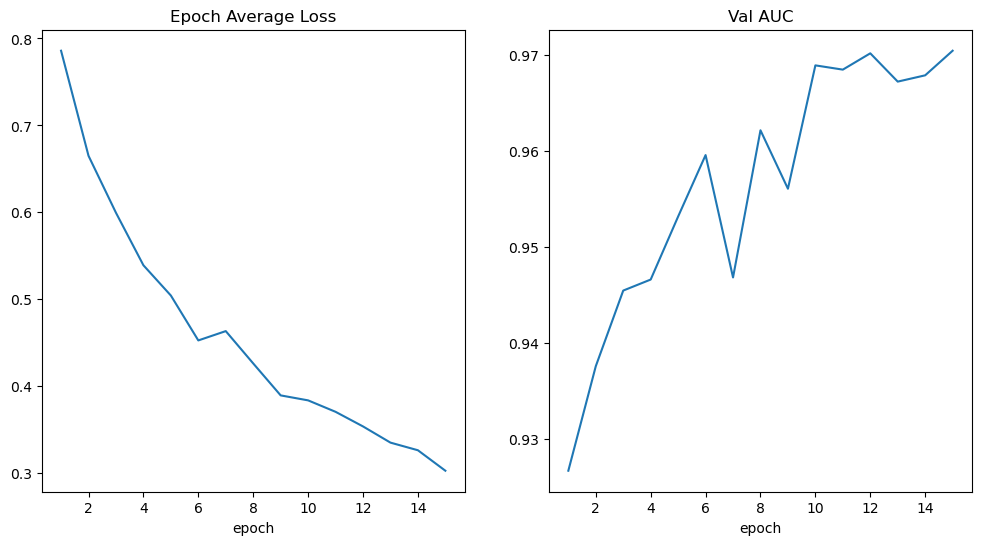

In [25]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

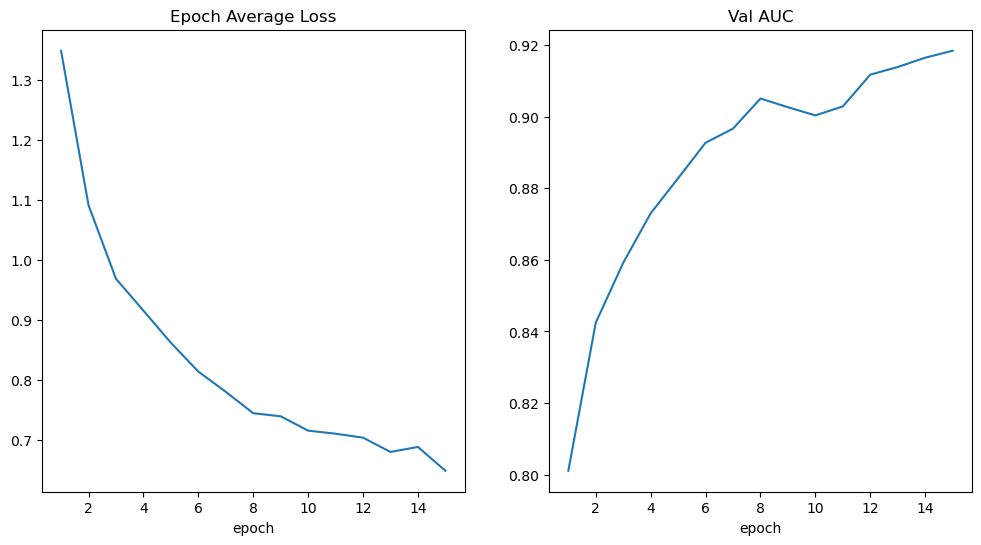

In [77]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [26]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                  precision    recall  f1-score   support

    glioma_tumor     0.7500    0.1800    0.2903       100
meningioma_tumor     0.7357    0.8957    0.8078       115
        no_tumor     0.6023    0.9810    0.7464       105
 pituitary_tumor     0.8475    0.6757    0.7519        74

        accuracy                         0.6954       394
       macro avg     0.7339    0.6831    0.6491       394
    weighted avg     0.7248    0.6954    0.6496       394



In [78]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                  precision    recall  f1-score   support

    glioma_tumor     0.7895    0.1500    0.2521       100
meningioma_tumor     0.3582    0.2087    0.2637       115
        no_tumor     0.3188    0.6952    0.4371       105
 pituitary_tumor     0.4937    0.5270    0.5098        74

        accuracy                         0.3832       394
       macro avg     0.4900    0.3952    0.3657       394
    weighted avg     0.4826    0.3832    0.3532       394



In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

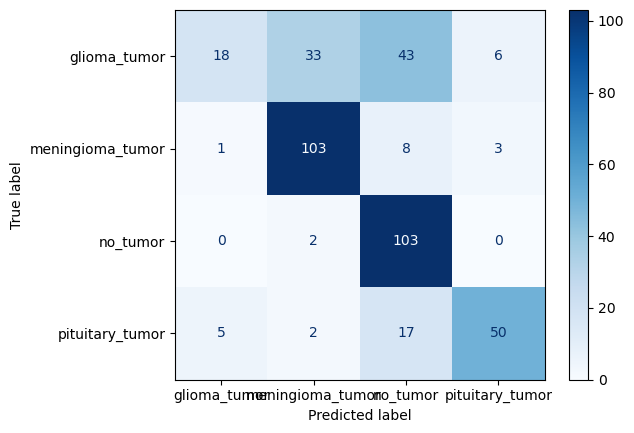

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()